In [7]:
from sklearn import datasets
import numpy as np

In [11]:
arr = np.zeros((5,20))

In [12]:
arr[0,0] = 1

In [14]:
arr[0,1] = 1

In [16]:
arr[1,0:2] = [1,-1]
arr[2,0:2] = [-1,1]
arr[3,0:2] = [-1,-1]
arr[4,2] = 5

In [17]:
arr

array([[ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [19]:
data, labels = datasets.make_blobs(n_samples=200, n_features=20, centers = arr, cluster_std=0.2)

In [20]:
from sklearn import decomposition 

In [21]:
pca = decomposition.PCA(n_components=2)

In [23]:
pca_data = pca.fit_transform(data)

In [24]:
import matplotlib.pyplot as plt

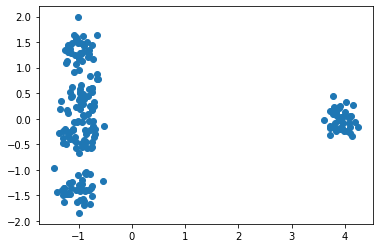

In [26]:
plt.scatter(pca_data[:,0], pca_data[:,1])

In [ ]:
import numpy as np
from sklearn.metrics import pairwise, normalized_mutual_info_score, adjusted_rand_score
import networkx as nx
from matplotlib import pyplot as plt
from optimize.functions import MSTER, LCR, loss, grad, H
from sklearn.cluster import KMeans
from config import MFConfig
import pandas as pd
from sklearn.decomposition import PCA
import copy

num_points = 5000
num_clusters = 5
random_state = 1600

df = pd.read_csv('mnist_784_zip/data/mnist_784_csv.csv')
df = df.loc[df['class'].isin([0,1,4,6,8])]
df = df.sample(n=num_points, random_state=random_state)
labels = np.array(df['class'])
data = np.mat(df.drop('class', axis=1))

pca_0 = PCA(n_components = 30) #initial dim reduction for faster MST computation (from tSNE paper)
init_data = np.mat(pca_0.fit_transform(data))
(M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b) = MFConfig(M=init_data).dump()

pca = PCA(n_components = 2)
pca_init = np.mat(pca.fit_transform(init_data))

def train():
    global M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b
    A_best = A.copy()
    B_best = B.copy()

    # ratio_A, vertices_A = MSTER(A, k_A)
    # ratio_B, vertices_B = MSTER(B.T, k_B)
    ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
    loss_best = loss(M,A,B,ratio_A, lambda_, eta)
    for epoch in range(num_epochs):
        best = ''
        if (epoch%10)<5:
            # gradient = (-(M-A*B)*B.T - lambda_*grad(A,vertices_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            gradient = (-(M-A*B)*B.T - lambda_*grad(A,A_A, B_A, C_A, D_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_a:
                gradient = clip_a * gradient/n

            A = A - lr_a*gradient
        else:
            gradient = (-A.T*(M-A*B))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_b:
                gradient = clip_b * gradient/n

            B = B - lr_b*gradient

        # ratio_A, vertices_A = MSTER(A, k_A)
        # ratio_B, vertices_B = MSTER(B.T, k_B)
        ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
        loss_ = loss(M,A,B,ratio_A, lambda_, eta)

        if loss_<loss_best:
            A_best = A.copy()
            B_best = B.copy()
            best = 'best'
            loss_best = loss_

        lr_a -= lr_a_decay
        lr_b -= lr_b_decay
        lambda_ -= lambda_decay
        eta -= eta_decay

        print("epoch {0} --- \t loss: {1} \t norm contribution: {2} \t {3}".format(epoch,
                loss_, 0.5*np.linalg.norm(M-A*B, ord = 'fro')**2, best))

    return A_best,B_best #returns best model in terms of loss

if __name__ == '__main__':
    A_best, B_best = train()

    ### Dim Reduction
    base = {1: [], 4: [], 6: [], 8: [], 0: []} #{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 0: []}
    base_kmeans = {0: [], 1: [], 2: [], 3:[], 4:[]}
    legend = [1,4,6,8,0]

    _dict = copy.deepcopy(base)
    for i,row in enumerate(np.array(A_best)):
        _dict[labels[i]].append(row)

    plt.figure(1)
    plt.title('d=2 MSTER-ALS Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict.keys():
        plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
    plt.legend(legend)

    _dict2 = copy.deepcopy(base)
    for i,row in enumerate(np.array(pca_init)):
        _dict2[labels[i]].append(row)

    plt.figure(2)
    plt.title('d=2 PCA Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict2.keys():
        plt.scatter(np.array(_dict2[i])[:,0], np.array(_dict2[i])[:,1], alpha=0.6)
    plt.legend(legend)

    ### KMeans stuff

    predictions_MSTER = KMeans(n_clusters = num_clusters, random_state = random_state).fit(A_best).labels_
    predictions_PCA = KMeans(n_clusters = num_clusters, random_state = random_state).fit(pca_init).labels_

    plt.figure(3)
    plt.title('K-Means predictions for MSTER')
    _dict3 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(A_best)):
        _dict3[predictions_MSTER[i]].append(row)
    for i in _dict3.keys():
        plt.scatter(np.array(_dict3[i])[:,0], np.array(_dict3[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    plt.figure(4)
    plt.title('K-Means predictions for PCA')
    _dict4 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(pca_init)):
        _dict4[predictions_PCA[i]].append(row)
    for i in _dict4.keys():
        plt.scatter(np.array(_dict4[i])[:,0], np.array(_dict4[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    ### NMI
    score_MSTER = normalized_mutual_info_score(labels, predictions_MSTER)
    score_PCA = normalized_mutual_info_score(labels, predictions_PCA)

    print("MSTER NMI score: {} \n PCA NMI score: {}".format(score_MSTER, score_PCA))

    ### ARI
    score_MSTER = adjusted_rand_score(labels, predictions_MSTER)
    score_PCA = adjusted_rand_score(labels, predictions_PCA)

    print("MSTER Rand score: {} \n PCA Rand score: {}".format(score_MSTER, score_PCA))

    plt.show()


In [1]:
import os
import pandas as pd

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

In [2]:
pandas2ri.activate()

base = importr('base')

/home/mstrals/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:969: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [3]:
base.load("./tpe/tpe/data/protein.rda");


In [4]:
rdf_List = base.mget(base.ls())


In [5]:
pydf_dict = {}


In [24]:
readRDS = robjects.r['readRDS']


In [25]:
df = readRDS('./protein.rds')


In [29]:
df

array(['protein'], dtype='<U7')

In [16]:
import numpy as np

In [18]:
rdf_List[0].shape

(8515,)

In [30]:
import pyreadr

In [37]:
result = pyreadr.read_r('./new_protein.rds',) # also works for Rds


In [36]:
ls

archive/          mnist_784_zip.zip  protein.rds    tpe/
config.py         MNIST_prep.ipynb   __pycache__/   tpe.tar.gz
datapackage.json  new_protein.rds    random.ipynb   Train.ipynb
datasets.py       optimize/          README.md      train.py
mnist_784_zip/    protein.rdata      sauer1991.pdf  Untitled.ipynb


In [40]:
from rpy2.robjects import pandas2ri

In [41]:
pandas2ri.activate()

In [43]:
import rpy2.robjects as ro

In [44]:
dt = pd.DataFrame()

In [45]:
r_dt = ro.conversion.py2rpy(dt)

In [47]:
pd_dt = ro.conversion.rpy2py(base)

In [50]:
np.array(pd_dt)

array(rpy2.robjects.packages.Package as a <module 'base'>, dtype=object)

In [56]:
df = pd.read_csv("./tpe/tpe/data/radar.csv")

In [57]:
df

,Unnamed: 0,G,B,G.1,B.1,G.2,B.2,G.3,B.3,G.4,...,G.215,G.216,G.217,G.218,G.219,G.220,G.221,G.222,G.223,G.224
0,G,0.000000,2.776359,1.169728,4.772563,1.377347,3.049072,1.530471,4.803640,1.205018,...,2.411660,1.850561,1.575835,1.819822,2.545739,2.125122,2.284844,2.214063,1.967518,1.870675
1,B,2.776359,0.000000,3.380033,4.454509,2.540531,2.783883,2.753930,4.859196,3.472495,...,4.444855,3.838187,3.018289,3.800659,3.871057,4.151681,4.335354,4.278651,4.110176,3.929828
2,G,1.169728,3.380033,0.000000,4.671267,1.838508,3.129187,2.399696,4.679506,1.695460,...,1.582709,1.056673,1.295598,1.009586,2.030114,1.326592,1.456198,1.391267,1.192104,1.026578
3,B,4.772563,4.454509,4.671267,0.000000,4.728259,3.853289,5.509146,3.754628,5.587566,...,4.895289,4.602913,4.183019,4.480253,4.300088,4.810247,4.853090,4.830586,4.781328,4.731419
4,G,1.377347,2.540531,1.838508,4.728259,0.000000,2.721250,1.433354,4.871717,2.013416,...,3.290688,2.604777,1.894606,2.580156,3.019837,2.989063,3.163051,3.093763,2.859164,2.679004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,G,2.125122,4.151681,1.326592,4.810247,2.989063,3.568336,3.427182,4.773545,2.434970,...,0.659912,0.692844,1.758529,0.698158,1.934238,0.000000,0.488513,0.472514,0.650537,0.473288
347,G,2.284844,4.335354,1.456198,4.853090,3.163051,3.818409,3.569641,4.863369,2.531763,...,0.219611,0.725608,1.937601,0.763132,1.966100,0.488513,0.000000,0.130732,0.508128,0.672662
348,G,2.214063,4.278651,1.391267,4.830586,3.093763,3.777344,3.495807,4.812042,2.457184,...,0.259382,0.662692,1.888983,0.724567,1.961145,0.472514,0.130732,0.000000,0.413108,0.616479
349,G,1.967518,4.110176,1.192104,4.781328,2.859164,3.662524,3.205566,4.700995,2.162645,...,0.576736,0.603384,1.744903,0.694532,1.955529,0.650537,0.508128,0.413108,0.000000,0.593984


In [54]:
import sklearn

In [55]:
mds = sklearn.manifold.MDS (n_components=2, metric=True)

AttributeError: module 'sklearn' has no attribute 'manifold'